# Pipeline de Validación

Cargamos las tablas de validación desde el github. Estas contienen track_features y playlists de las 50 playlists con más canciones del dataset de 2000 playlists. Ya se encuentran limpiadas (ambas tablas sólo contienen info de canciones de menos de 15 minutos y sin valores nulos).

In [1]:
import pandas as pd
import numpy as np

playlists_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_playlists_validation.csv')
tracks_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_tracks_validation.csv')
artist_info = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/artist/2000_artist_sample.csv.gz')
cols=tracks_val.columns
tracks_val.columns=[col[15:] if col[:15]=="audio_features." else col for col in cols]
tracks_val.head(n=2)

,Unnamed: 0,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,0,spotify:track:3RCT90rX7F5rSwMwUU4Pz6,0.616,0.850,5,-5.419,0,0.0580,0.00216,0.0667,0.181,0.470,142.841,audio_features,3RCT90rX7F5rSwMwUU4Pz6,https://api.spotify.com/v1/tracks/3RCT90rX7F5r...,https://api.spotify.com/v1/audio-analysis/3RCT...,219560,4
1,1,spotify:track:2t5GyUfFoZg3E8ak3i7dVP,0.301,0.353,4,-15.588,0,0.0467,0.77800,0.4890,0.406,0.189,134.588,audio_features,2t5GyUfFoZg3E8ak3i7dVP,https://api.spotify.com/v1/tracks/2t5GyUfFoZg3...,https://api.spotify.com/v1/audio-analysis/2t5G...,621107,3


`var_names` para obtener los features que nos sirven y `tracks_info` para obtener información de una canción dada una `uri`

In [2]:
var_names=["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
tracks_info = playlists_val.drop_duplicates(subset=["track_uri"]).set_index("track_uri")[["track_name", "artist_name"]].loc[tracks_val["uri"]]

Definir clases para cada recomendador y así poder evaluarlos. Colocarlas en el espacio y formato del siguiente 
_template_:

```python
#Colocar acá las clases de sus clasificadores.
#Pueden o no tener init o train, pero deben tener una función recommend_list
class recommender_x:
    def __init__(self):
        pass
    #Puede no tener train, dependiendo de cómo funcione. Pero debe utilizar las canciones dentro del dataset de validación.
    def train(self, tracks_df, playlists_df):
        pass
    #Esta función DEBE tomar como input un dataframe de canciones.
    #Debe tambien tomar el argumento "number" para setear el número de recomendaciones
    def recommend_list(self, canciones_df, number=100, **kwargs):
        #DEBE retornar una lista de uris de las canciones output 
        return None
```

Calculamos la métrica en los datos de validación. Para una lista dada, se eligen aleatoreamente 20 canciones que pertenezcan a la lista y se obtienen N-20 recomendaciones, donde N es la cantidad de canciones de la lista (las listas del dataset de validación tienen entre 210-375 canciones). Luego, evalúa qué porcentaje de las N-20 canciones output pertenecen a la lista original. Repite este proceso. Se grafica el histograma de desempeño del recomendador.

In [3]:
import matplotlib.pyplot as plt

np.random.seed(1991)

def validar_lista(pid, recomendador):
    input_uris= list(set(playlists_val[playlists_val["pid"]==pid]["track_uri"]))
    input_df=tracks_val.set_index("uri").loc[np.random.choice(input_uris, 20)]
    output_uris= recomendador.recommend_list(input_df, number=len(input_uris)-20)
    output_pid= playlists_val.set_index("track_uri").loc[output_uris]["pid"]
    return sum(output_pid==pid)*100.0/(len(input_uris)-20)

def validar_recomendador(recomendador):
    porcentajes=[]
    for i, pid in enumerate(list(set(playlists_val["pid"]))):
        porcentajes.append(validar_lista(pid, recomendador))
        print(i+1,"de", len(set(playlists_val["pid"]))) if (i+1)%5==0 else None
    plt.hist(porcentajes)
    return np.mean(porcentajes)

## Sistema de Recomendación 1: Matriz de próximidad

In [4]:
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity

class recommender_1:
  def __init__(self):
    self.proximity_matrix=None
    self.obs_labels=None
    self.N_nearest=None
    self.artist=None
    self.pid_id=None
    self.avg_features_by_pid=None

  def fit(self, X, y, artist):
    """Almacena la matriz de proximidad y guarda los PID en self.obs_labels"""
    self.avg_features_by_pid = X
    self.obs_labels = y
    self.proximity_matrix = distance_matrix(X, X)
    self.artist = artist
    
  def refit(self):
    """Actualiza la matriz de distancia en base a self.avg_features_by_pid"""
    self.proximity_matrix = distance_matrix(self.avg_features_by_pid, self.avg_features_by_pid)
    
  def recommend_list(self, canciones_df, number=2, N=50, **kwargs):
    """
       Recibe un set de canciones sin PID con sus track_features (canciones_df).
       Se recomputa self.proximity_matrix agregando el nuevo set de canciones
       como PID "pivote". Se deja reservado el PID 0 para este set de canciones.
       
           - canciones_df: dataframe con una lista de canciones
           - number: número de canciones requeridas para recomendar
           - N: número de playlist cercanas para ir a buscar candidatos de canciones
    """
    # Preproceso para computar el vector de características promedio
    canciones_df = \
            canciones_df.reset_index() \
            [['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
        
    track_set = pd.concat([pd.DataFrame({'PID': np.zeros(canciones_df.shape[0], 'int32')}),
                           canciones_df], axis=1)
        
    # Se computa el vector de características promedio del set de canciones recibido
    track_set = track_set.groupby('PID').mean().reset_index()
   
    # Concatenar al principio del atributo self.avg_features_by_pid y self.obs_labels
    self.avg_features_by_pid = np.r_[track_set.iloc[:, 1:], self.avg_features_by_pid]
    self.obs_labels = np.r_[0, self.obs_labels]
    
    # Actualizar matriz de distancia
    self.refit()
    
    # Actualizar listas mas cercanas (siempre es el PID en la posición 0)
    nearest_index = np.argsort(self.proximity_matrix[0, :])[:N+1][1:]
    self.N_nearest = self.obs_labels[nearest_index]
    
    # Se cambia el atributo pid_id la cual es la lista objetivo para buscar las recomendaciones
    self.pid_id = 0
    
    # Entregar recomendaciones
    return self.get_recommendations(num_tracks=number)
    
  def get_recommendations(self, num_tracks=20):
    """Dado un track de canciones arbitarias, se utiliza por el método
       recommend_given_track_set
    """ 
    recommended_songs_list = self.artist[self.artist.pid.isin(self.N_nearest)].copy()
    recommended_songs_list = recommended_songs_list.drop_duplicates(subset=['artist_uri'])
    
    # Seleccionar solo los features de las canciones
    features_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 
     'speechiness', 'acousticness', 'instrumentalness', 
     'liveness', 'valence', 'tempo']
    
    # Obtenemos las canciones candidatas     
    recommended_songs_list['similarity'] = np.dot(recommended_songs_list[features_columns].to_numpy(), 
                                                  self.avg_features_by_pid[0, :].reshape(11, 1))
    recommended_songs_list = recommended_songs_list.sort_values(by=['similarity'], ascending=True)
    
    # Se eliminan los duplicados.
    recommended_songs_list = recommended_songs_list.drop_duplicates(subset=['artist_uri'])
    
    # Se retorna el número de canciones, 2: track_uri
    return recommended_songs_list.iloc[:num_tracks, 2]

El modelo requiere memorizar el vector de características promedio de cada lista en el set de entrenamiento.
Por lo tanto, se debe cruzar la tabla con la información de las listas con los _track features_ de cada una 
de las canciones que contienen las _playlists_, para luego agregarlas en un vector promedio de _track features_ por lista.

In [5]:
avg_features_by_pid = \
        playlists_val \
            .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
            [['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
            .groupby('pid') \
            .mean() \
            .reset_index()

In [6]:
features_by_pid_plus_artist = \
    playlists_val \
    .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
    [['pid','artist_uri', 'track_uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
    .drop_duplicates(subset=['artist_uri']) \
    .merge(artist_info[['artists.uri', 'artists.popularity']], left_on='artist_uri', right_on='artists.uri', how='left') \
    .drop(['artists.uri'], axis=1)

In [7]:
recomendador_1 =recommender_1()
recomendador_1.fit(avg_features_by_pid.iloc[:, 1:].to_numpy(), 
                   avg_features_by_pid.iloc[:, 0].to_numpy(),
                   features_by_pid_plus_artist)

5 de 50
10 de 50
15 de 50
20 de 50
25 de 50
30 de 50
35 de 50
40 de 50
45 de 50
50 de 50
Eficiencia recomendador 1: 2.6703181852159212 %


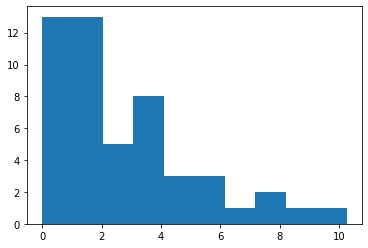

In [8]:
np.random.seed(1991)
eficiencia_1=validar_recomendador(recomendador_1)
print("Eficiencia recomendador 1:", eficiencia_1,"%")

## Sistema de Recomendación 2: Multi-label logistic regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

class recommender_2:
    def __init__(self):
        pass
    
    def train(self, tracks_df, playlists_df):
        self.tracks_df, self.playlists_df = tracks_df, playlists_df
        playlist_ids=list(set(playlists_df["pid"]))
        self.X_ori=np.asarray(tracks_df[var_names])
        self.X=(self.X_ori-np.tile(np.mean(self.X_ori, axis=0), (self.X_ori.shape[0], 1)))/np.tile(np.std(self.X_ori, axis=0), (self.X_ori.shape[0], 1))
        self.X_t=PolynomialFeatures(1).fit_transform(self.X)
        self.W=np.zeros(0)
        total=len(playlist_ids)
        self.lists=np.zeros(shape=(len(self.X), total))-1
        for playlist_i in range(total):
            print(playlist_i) if (playlist_i % (total/5))==0 else None
            this_playlist=playlists_df[playlists_df["pid"]==playlist_ids[playlist_i]]
            y=1*tracks_df["uri"].isin(this_playlist["track_uri"])
            if(sum(y))>0:
                self.lists[y==1, playlist_i]=playlist_i
                clf=LogisticRegression(fit_intercept=False)
                clf.fit(self.X_t, y)
                self.W=np.append(self.W, clf.coef_)
        self.lists=np.asarray(self.lists)
        self.W=self.W.reshape(-1, clf.coef_.size)
        ret=np.exp(self.X_t @ self.W.T-10)
        self.probas=ret/np.tile(np.apply_along_axis(sum, 1, ret), (self.W.T.shape[1],1)).T
        
    def recommend_list(self, canciones_df, suavizado=1000, number=100, exclude_same=True):
        canciones=np.asarray(canciones_df[var_names])
        canciones=np.asarray(canciones).reshape(-1, 13)
        canciones=(canciones-np.tile(np.mean(self.X_ori, axis=0), (canciones.shape[0], 1)))/np.tile(np.std(self.X_ori, axis=0), (canciones.shape[0], 1))
        canciones_t=PolynomialFeatures(1).fit_transform(canciones)
        matmult=np.exp(canciones_t @ self.W.T-10)
        probas_canciones=matmult/np.tile(np.apply_along_axis(sum, 1, matmult), (self.W.T.shape[1],1)).T
        puntajes=np.zeros(len(self.X))
        not_in_input=np.ones(len(self.X))
        for this_proba in probas_canciones:
            distancia_proba=np.asarray([np.linalg.norm(this_proba-proba) for proba in self.probas])
            not_in_input=not_in_input*(distancia_proba>1e-15)*1 if exclude_same else not_in_input
            order=np.argsort(np.argsort(distancia_proba))
            puntajes+=np.exp(-order*len(canciones)/suavizado)
        puntajes=puntajes*not_in_input if exclude_same else puntajes
        final_order=np.argsort(-puntajes)
        y_recom=np.zeros(len(self.X))
        y_recom[final_order[:number]]=1
        return self.tracks_df.iloc[final_order][:number]["uri"]

recomendador_2=recommender_2()
recomendador_2.train(tracks_val, playlists_val)

0
10
20
30
40


5 de 50
10 de 50
15 de 50
20 de 50
25 de 50
30 de 50
35 de 50
40 de 50
45 de 50
50 de 50
Eficiencia recomendador 2: 14.627791132965505 %


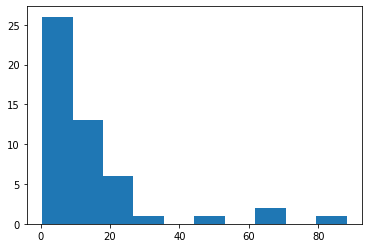

In [10]:
np.random.seed(1991)
eficiencia_2=validar_recomendador(recomendador_2)
print("Eficiencia recomendador 2:", eficiencia_2,"%")

## Sistema de Recomendación 3: Autoencoder

In [11]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import StandardScaler

In [12]:
# Se crea la clase autoencoder.
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(11, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 8),
            nn.ReLU(),
            nn.Linear(8, 10),
            nn.ReLU(),
            nn.Linear(10, 11))
        
    def predict(self, data):
        return self.encoder(data)

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        return decoder 

In [13]:
# Se crea la clase GenerateDataset para leer los datos.
class GenerateDataset(Dataset):
    def __init__(self, numpy_array):
        self.numpy_array = numpy_array

    def __len__(self):
        return len(self.numpy_array)

    def __getitem__(self, idx):
        data = self.numpy_array[idx]
        x = np.isnan(data)
        data[x] = 0
        return data

In [14]:
class recommender_3:
    def __init__(self, path="../data/models/modelo_50e_256b_decay.pth"):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = autoencoder().to(self.device)
        self.model.load_state_dict(torch.load(path))
        self.data = None
        self.processed_data = []
        self.processed_data_df = None
        self.scaler = StandardScaler()
        
    def load_data(self, tracks_val):
        self.scaler.fit(tracks_val.iloc[:, 2:-6])
        tracks_val_np = self.scaler.transform(tracks_val.iloc[:, 2:-6])
        self.data = DataLoader(GenerateDataset(tracks_val_np.astype('f')),
                    batch_size=1, shuffle=False)
        
        for data in self.data:
            data = data.to(self.device)
            self.processed_data.append(self.model.predict(data).detach().cpu().numpy()[0])
        
        self.processed_data_df = pd.DataFrame(self.processed_data, columns=['comp_1','comp_2'])
        self.processed_data_df = self.processed_data_df.assign(uri=tracks_val['uri'])
    
    
    #Esta función DEBE tomar como input un dataframe de canciones.
    #Debe tambien tomar el argumento "number" para setear el número de recomendaciones
    def recommend_list(self, canciones_df, number=100, **kwargs):
        canciones_np = self.scaler.transform(canciones_df[var_names[:-2]])
        canciones_dl = DataLoader(GenerateDataset(canciones_np.astype('f')),
                    batch_size=1, shuffle=False)
        
        data_inference = []
        for data in canciones_dl:
            data = data.to(self.device)
            data_inference.append(self.model.predict(data).detach().cpu().numpy()[0])
        
        data_inference_df = pd.DataFrame(data_inference, columns=['comp_1','comp_2'])
        canciones_df = canciones_df.reset_index()
        data_inference_df = data_inference_df.assign(uri=canciones_df["uri"])
        
        # inferencia
        recommendations = []
        amount = int(number/canciones_df.shape[0]) + 5
        for i in range(canciones_df.shape[0]):
            # Se toma la primera playlist/cancion y se pasa a tensor.
            playlist_input = torch.tensor(data_inference_df.iloc[i:i+1,:2].to_numpy())
            
            # processed_data_df son las canciones procesadas por .encoder (espacio latente).
            dataset_latente = torch.tensor(self.processed_data_df.iloc[:,:2].to_numpy())

            # Se buscan las canciones mas cercanas a la playlist/cancion de input.
            result_cdist = torch.cdist(playlist_input, dataset_latente, p=2)

            # Se ordenan los valores.
            result_cdist_sort = [x.item() for x in np.argsort(result_cdist)[0]][:amount]
            recommendations.extend(result_cdist_sort)
            
        return self.processed_data_df.iloc[recommendations[1:number+1], 2]

In [15]:
recomendador_3 = recommender_3()

In [16]:
recomendador_3.load_data(tracks_val)

5 de 50
10 de 50
15 de 50
20 de 50
25 de 50
30 de 50
35 de 50
40 de 50
45 de 50
50 de 50
Eficiencia recomendador 3: 13.600943728801527 %


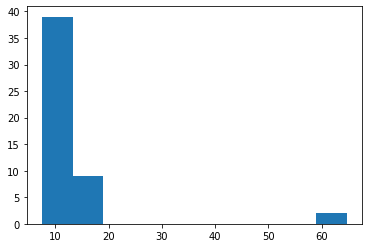

In [17]:
np.random.seed(1991)
eficiencia_3 = validar_recomendador(recomendador_3)
print("Eficiencia recomendador 3:", eficiencia_3,"%")